Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

This notebook is divided into 6 parts:

**Bidirectional LSTMs**

**Sequence Classification Problem**

**LSTM For Sequence Classification**

**Bidirectional LSTM For Sequence Classification**

**Compare LSTM to Bidirectional LSTM**

**Comparing Bidirectional LSTM Merge Modes**

**Bidirectional LSTMs**
The idea of Bidirectional Recurrent Neural Networks (RNNs) is straightforward.

It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

The use of bidirectional LSTMs may not make sense for all sequence prediction problems, but can offer some benefit in terms of better results to those domains where it is appropriate.

**Bidirectional layers in keras**

Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper. This wrapper takes a recurrent layer (e.g. the first LSTM layer) as an argument. It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The options are:

**'sum‘: The outputs are added together.**

**‘mul‘: The outputs are multiplied together.**

**‘concat‘: The outputs are concatenated together (the default), providing double the number of outputs to the next layer.**

**‘ave‘: The average of the outputs is taken.**

The default mode is to concatenate, and this is the method often used in studies of bidirectional LSTMs.

**Sequence Classification Problem**

We will define a simple sequence classification problem to explore bidirectional LSTMs. 

The problem is defined as a sequence of random values between 0 and 1. This sequence is taken as input for the problem with each number provided one per timestep. We can implement this in Python.

The first step is to generate a sequence of random values. We can use the random() function from the random module.

In [ ]:
# create a sequence of random numbers in [0,1]
X = array([random() for _ in range(10)])

We can define the threshold as one-quarter the length of the input sequence.

In [ ]:
# calculate cut-off value to change class values
limit = 10/4.0

The cumulative sum of the input sequence can be calculated using the cumsum() NumPy function. This function returns a sequence of cumulative sum values, e.g.:

In [ ]:
pos1, pos1+pos2, pos1+pos2+pos3, ...

We can then calculate the output sequence as whether each cumulative sum value exceeded the threshold.

In [ ]:
# determine the class outcome for each item in cumulative sequence
y = array([0 if x < limit else 1 for x in cumsum(X)])

The function below, named get_sequence(), draws all of this together, taking as input the length of the sequence, and returns the X and y components of a new problem case.

In [1]:
from random import random
from numpy import array
from numpy import cumsum

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	return X, y

We can test this function with a new 10 timestep sequence as follows:

In [2]:
X, y = get_sequence(10)
print(X)
print(y)

[0.82290995 0.16938786 0.41231019 0.97203228 0.74629037 0.72049283
 0.23182411 0.21130716 0.02579848 0.67585097]
[0 0 0 0 1 1 1 1 1 1]


**LSTM For Sequence Classification**
We can start off by developing a traditional LSTM for the sequence classification problem. Firstly, we must update the get_sequence() function to reshape the input and output sequences to be 3-dimensional to meet the expectations of the LSTM. The classification problem has 1 sample (e.g. one sequence), a configurable number of timesteps, and one feature per timestep.

Therefore, we can reshape the sequences as follows.

In [3]:
# reshape input and output data to be suitable for LSTMs
X = X.reshape(1, n_timesteps, 1)
y = y.reshape(1, n_timesteps, 1)

NameError: ignored

The updated get_sequence() function is listed below.

In [4]:
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

Next, we can define an LSTM for the problem. The input layer will have 10 timesteps with 1 feature a piece, input_shape=(10, 1). 

The first hidden layer will have 20 memory units and the output layer will be a fully connected layer that outputs one value per timestep. A sigmoid activation function is used on the output to predict the binary value. 

A TimeDistributed wrapper layer is used around the output layer so that one value per timestep can be predicted given the full sequence provided as input. This requires that the LSTM hidden layer returns a sequence of values (one per timestep) rather than a single value for the whole input sequence.

Finally, because this is a binary classification problem, the binary log loss (binary_crossentropy in Keras) is used. The efficient ADAM optimization algorithm is used to find the weights and the accuracy metric is calculated and reported each epoch.

In [ ]:
# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(10, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

The LSTM will be trained for 1,000 epochs. A new random input sequence will be generated each epoch for the network to be fit on. This ensures that the model does not memorize a single sequence and instead can generalize a solution to solve all possible random input sequences for this problem.

In [ ]:
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)

Once trained, the network will be evaluated on yet another random sequence. The predictions will be then compared to the expected output sequence to provide a concrete example of the skill of the system.

In [ ]:
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

the complete example is listed below:

In [5]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

1/1 - 0s - loss: 0.7001 - accuracy: 0.4000
1/1 - 0s - loss: 0.6965 - accuracy: 0.3000
1/1 - 0s - loss: 0.6919 - accuracy: 0.5000
1/1 - 0s - loss: 0.6878 - accuracy: 0.9000
1/1 - 0s - loss: 0.6939 - accuracy: 0.3000
1/1 - 0s - loss: 0.6874 - accuracy: 0.5000
1/1 - 0s - loss: 0.6803 - accuracy: 0.6000
1/1 - 0s - loss: 0.6868 - accuracy: 0.6000
1/1 - 0s - loss: 0.6835 - accuracy: 0.5000
1/1 - 0s - loss: 0.6684 - accuracy: 0.7000
1/1 - 0s - loss: 0.6732 - accuracy: 0.6000
1/1 - 0s - loss: 0.6801 - accuracy: 0.5000
1/1 - 0s - loss: 0.6671 - accuracy: 0.6000
1/1 - 0s - loss: 0.6602 - accuracy: 0.6000
1/1 - 0s - loss: 0.6830 - accuracy: 0.4000
1/1 - 0s - loss: 0.6857 - accuracy: 0.4000
1/1 - 0s - loss: 0.6389 - accuracy: 0.7000
1/1 - 0s - loss: 0.6866 - accuracy: 0.4000
1/1 - 0s - loss: 0.6630 - accuracy: 0.5000
1/1 - 0s - loss: 0.6484 - accuracy: 0.6000
1/1 - 0s - loss: 0.6592 - accuracy: 0.5000
1/1 - 0s - loss: 0.6439 - accuracy: 0.6000
1/1 - 0s - loss: 0.6550 - accuracy: 0.5000
1/1 - 0s - 

**Bidirectional LSTM For Sequence Classification**

Now that we know how to develop an LSTM for the sequence classification problem, we can extend the example to demonstrate a Bidirectional LSTM.

We can do this by wrapping the LSTM hidden layer with a Bidirectional layer, as follows:

In [ ]:
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))

This will create two copies of the hidden layer, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be concatenated.

That means that instead of the TimeDistributed layer receiving 10 timesteps of 20 outputs, it will now receive 10 timesteps of 40 (20 units + 20 units) outputs.

This complete example is listed below:

In [6]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train LSTM
for epoch in range(1000):
	# generate new random sequence
	X,y = get_sequence(n_timesteps)
	# fit model for one epoch on this sequence
	model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
	print('Expected:', y[0, i], 'Predicted', yhat[0, i])

1/1 - 0s - loss: 0.6711 - accuracy: 0.5000
1/1 - 0s - loss: 0.6768 - accuracy: 0.4000
1/1 - 0s - loss: 0.6474 - accuracy: 0.9000
1/1 - 0s - loss: 0.6780 - accuracy: 0.4000
1/1 - 0s - loss: 0.6835 - accuracy: 0.4000
1/1 - 0s - loss: 0.6562 - accuracy: 0.7000
1/1 - 0s - loss: 0.6621 - accuracy: 0.7000
1/1 - 0s - loss: 0.6679 - accuracy: 0.5000
1/1 - 0s - loss: 0.6576 - accuracy: 0.6000
1/1 - 0s - loss: 0.6797 - accuracy: 0.5000
1/1 - 0s - loss: 0.6359 - accuracy: 0.9000
1/1 - 0s - loss: 0.6806 - accuracy: 0.4000
1/1 - 0s - loss: 0.6574 - accuracy: 0.6000
1/1 - 0s - loss: 0.6399 - accuracy: 0.8000
1/1 - 0s - loss: 0.6493 - accuracy: 0.7000
1/1 - 0s - loss: 0.6421 - accuracy: 0.7000
1/1 - 0s - loss: 0.6478 - accuracy: 0.9000
1/1 - 0s - loss: 0.6725 - accuracy: 0.5000
1/1 - 0s - loss: 0.6450 - accuracy: 0.9000
1/1 - 0s - loss: 0.6426 - accuracy: 0.7000
1/1 - 0s - loss: 0.6456 - accuracy: 0.9000
1/1 - 0s - loss: 0.6705 - accuracy: 0.5000
1/1 - 0s - loss: 0.6149 - accuracy: 0.8000
1/1 - 0s - 

**Compare LSTM to Bidirectional LSTM**

In this example, we will compare the performance of traditional LSTMs to a Bidirectional LSTM over time while the models are being trained.

We will adjust the experiment so that the models are only trained for 250 epochs. This is so that we can get a clear idea of how learning unfolds for each model and how the learning behavior differs with bidirectional LSTMs.

We will compare three different models:

1. LSTM

2. LSTM with reversed input sequences

3. Bidirectional LSTM

This comparison will help to show that bidirectional LSTMs can in fact add something more than simply reversing the input sequence.

We will define a function to create and return an LSTM with either forward or backward input sequences, as follows:

In [7]:
def get_lstm_model(n_timesteps, backwards):
	model = Sequential()
	model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

We can develop a similar function for bidirectional LSTMs where the merge mode can be specified as an argument. The default of concatenation can be specified by setting the merge mode to the value ‘concat’.

In [8]:
def get_bi_lstm_model(n_timesteps, mode):
	model = Sequential()
	model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

Finally, we define a function to fit a model and retrieve and store the loss each training epoch, then return a list of the collected loss values after the model is fit. This is so that we can graph the log loss from each model configuration and compare them.



In [9]:
def train_model(model, n_timesteps):
	loss = list()
	for _ in range(250):
		# generate new random sequence
		X,y = get_sequence(n_timesteps)
		# fit model for one epoch on this sequence
		hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
		loss.append(hist.history['loss'][0])
	return loss

Putting this all together, the complete example is listed below.First a traditional LSTM is created and fit and the log loss values plot. This is repeated with an LSTM with reversed input sequences and finally an LSTM with a concatenated merge.

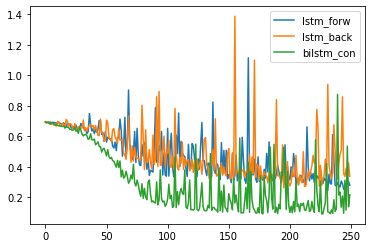

In [10]:
from random import random
from numpy import array
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

def get_lstm_model(n_timesteps, backwards):
	model = Sequential()
	model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

def get_bi_lstm_model(n_timesteps, mode):
	model = Sequential()
	model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

def train_model(model, n_timesteps):
	loss = list()
	for _ in range(250):
		# generate new random sequence
		X,y = get_sequence(n_timesteps)
		# fit model for one epoch on this sequence
		hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
		loss.append(hist.history['loss'][0])
	return loss


n_timesteps = 10
results = DataFrame()
# lstm forwards
model = get_lstm_model(n_timesteps, False)
results['lstm_forw'] = train_model(model, n_timesteps)
# lstm backwards
model = get_lstm_model(n_timesteps, True)
results['lstm_back'] = train_model(model, n_timesteps)
# bidirectional concat
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)
# line plot of results
results.plot()
pyplot.show()

**Comparing Bidirectional LSTM Merge Modes**

There a 4 different merge modes that can be used to combine the outcomes of the Bidirectional LSTM layers. They are concatenation (default), multiplication, average, and sum. We can compare the behavior of different merge modes by updating the example from the previous section as follows:

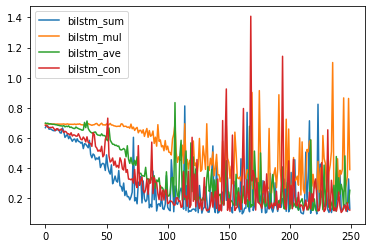

In [11]:
n_timesteps = 10
results = DataFrame()
# sum merge
model = get_bi_lstm_model(n_timesteps, 'sum')
results['bilstm_sum'] = train_model(model, n_timesteps)
# mul merge
model = get_bi_lstm_model(n_timesteps, 'mul')
results['bilstm_mul'] = train_model(model, n_timesteps)
# avg merge
model = get_bi_lstm_model(n_timesteps, 'ave')
results['bilstm_ave'] = train_model(model, n_timesteps)
# concat merge
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)
# line plot of results
results.plot()
pyplot.show()